# single text(sentence) classification

- 과학 기술 태그(9) + 기술 문서 태그(4) = (11)
- 전처리 유무 : O
- Data Sampling : X

## module import

In [1]:
import torch
import pandas as pd
import numpy as np; import random
import os

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import BertForSequenceClassification, BertTokenizerFast

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [3]:
os.listdir()

['.ipynb_checkpoints', 'fine_tuning.ipynb', 'logs', 'output', 'wandb']

In [4]:
# vocab_path: str = './vocab'
# model_path: str = './40ep_train9/'
# data_path: str = './total_v2.1.csv'
# output_path: str = './output/'
vocab_path: str = 'F:/Dropbox/BERT/bert_code/pre_training/vocab/'
model_path: str = 'F:/Dropbox/BERT/bert_code/pre_training/model_checkpoint_dir_40000/40ep_train9/'
data_path: str = 'F:/Dropbox/Kisti2022공유/데이터구축/final/total_v2.1.csv'
output_path: str = './output/'

# fine tuning models
final_model : str = './output/checkpoint-12700/'
acc_model : str = './output/checkpoint-254/'
f1_model : str = './output/checkpoint-1524/'

In [5]:
# randomness 제어
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
set_seed(12345)

In [6]:
import wandb
!wandb login 

wandb: Currently logged in as: hyez. Use `wandb login --relogin` to force relogin


## Load Dataset

In [7]:
df = pd.read_csv(data_path)
print(df.shape)
print(df.isna().sum())
df.head()

(185478, 3)
text      0
tag       0
source    0
dtype: int64


,text,tag,source
0,비접촉식 상황인지 센서: 움직이는 대상물 탐지센서,기술의 파급효과,etri
1,"비접촉 생체신호 모니터링 의료용기기, 헬스케어모니터링 기기",기술의 파급효과,etri
2,차량내 운전자 상태 모니터링 센서,기술의 파급효과,etri
3,"강설량 측정, 비파괴 벽투과 센서",기술의 파급효과,etri
4,재난 안전 모니터링용 센서 및 안전 사고후 비가시 영역 탐지 센서,기술의 파급효과,etri


In [8]:
# 결측치 제거
df = df.dropna()

- input : text
- label : tag

In [9]:
# y dict 생성
possible_labels = df.tag.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

# label encoding
df['labels'] = df.tag.replace(label_dict)

In [10]:
set_seed(12345)
# train : val : test = 70 : 10 : 20
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.labels.values, 
                                                  test_size=0.30, random_state=12345, stratify=df.labels.values)
X_val, X_test, y_val, y_test = train_test_split(df.loc[X_val].index.values, df.loc[X_val].labels.values, 
                                                  test_size=0.66, random_state=12345, stratify=df.loc[X_val].labels.values)

train, val, test = df.loc[X_train, ['text', 'labels']].reset_index(drop=True), df.loc[X_val, ['text', 'labels']].reset_index(drop=True), df.loc[X_test, ['text', 'labels']].reset_index(drop=True)

In [11]:
# make Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)
dataset = DatasetDict({"train": train_dataset, "val": val_dataset, "test": test_dataset})

In [12]:
example = train_dataset[0]
print(example)

{'text': '컴퓨터에게 시각 지능을 부여하여 위험 상황이나 지속적인 모니터링이 필요한 분야에서 사람을 대신할 수 있고, 사람이 상황을 판단하는데 보조적인 역할 수행 가능', 'labels': 1}


## tokenizer load 
- __call__ : https://github.com/huggingface/transformers/blob/v4.20.1/src/transformers/tokenization_utils_base.py#L2409

In [13]:
tokenizer = BertTokenizerFast.from_pretrained(vocab_path, do_lower_case=False, model_max_length=128)
print(tokenizer.__class__)
## vocab 확인
sorted(tokenizer.vocab.items(), key = lambda item: item[1])[:10]

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


[('[PAD]', 0),
 ('[UNK]', 1),
 ('[CLS]', 2),
 ('[SEP]', 3),
 ('[MASK]', 4),
 ('!', 5),
 ('"', 6),
 ('#', 7),
 ('$', 8),
 ('%', 9)]

C:\Users\HYEJI\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


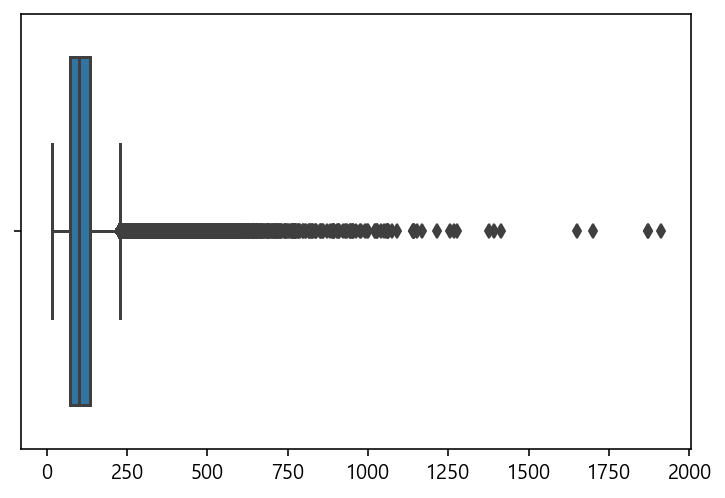

In [14]:
sns.boxplot(df.text.apply(lambda x: len(x)).tolist())

In [15]:
df[df.text.apply(lambda x: len(x) > 1000)] # 시장동향	과학기술일자리진흥원
df[df.text.apply(lambda x: len(x) > 250)].tag.value_counts()

시장동향        1718
제안 방법        620
대상 데이터       609
성능/효과        535
기술 정의        270
문제 정의        267
이론/모형        229
데이터처리        162
후속연구         145
기술의 필요성       65
기술동향          26
기술의 파급효과      22
가설 설정          5
Name: tag, dtype: int64

Token indices sequence length is longer than the specified maximum sequence length for this model (151 > 128). Running this sequence through the model will result in indexing errors
C:\Users\HYEJI\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


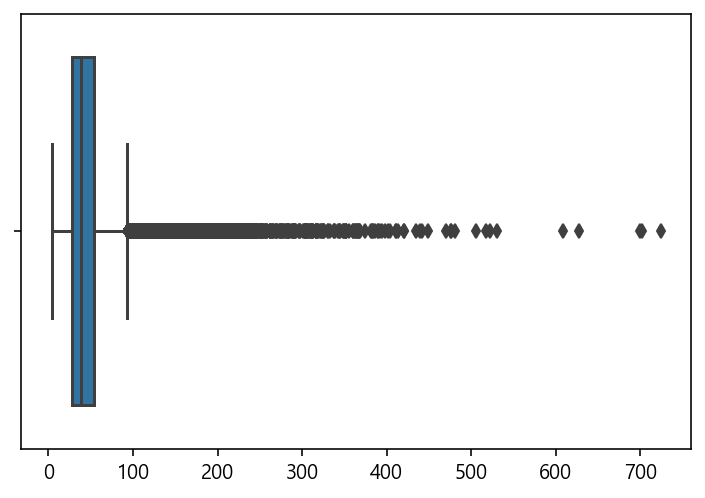

In [16]:
sns.boxplot(df.text.apply(lambda x: len(tokenizer(x)['input_ids'])).tolist())

In [141]:
aa  = df.text.apply(lambda x: len(tokenizer(x)['input_ids']))

In [169]:
df[aa > 150].source.value_counts()

kisti         699
과학기술일자리진흥원    667
중소기업기술로드맵       4
etri            3
Name: source, dtype: int64

In [170]:
for i, t, s in zip(df[aa > 300][50:].text, df[aa > 300][50:].tag, df[aa > 300][50:].source):
    print(t, s)
    print(i)
    print()

시장동향 과학기술일자리진흥원
국내 및 전망LPG 차량 등록 대수는 집계가 이뤄진 1999년 이후 해마다 증가했 2000년 121만4천83대로 처음으로 100만대에 진입하였고 2006년에는 등록 대수 200만대 시대를 열었 이후에도 꾸준한 증가세를 보여 2010년에는 245만5천696대로 최고치를 보였 저공해 LPG엔진개조 사업의 시장규모는 수도권 대기환경관리 기본계획과 2007년 국고보조사업 신청지침에 따라 아래 표와 같이 2005년부터 2014년까지 총 230,429대로 9,412억원  의 예산이 계획되어 있 해외 및 전망세계 70여개국에서 운행 중인 LPG자동차 보급대수가 큰 폭으로 늘어나 1,800만대를 돌파한 것으로 발표됐 세계LPG협회가 발간한 'Statistical Review of Global LP Gas'에 따르면, 2010년말 기준 전세계 LPG자동차 보유대수는 1,813만대로 전년 대비 9.7% 증가하여 가파른 성장세를 보여주고 있 2000년 이후 LPG자동차 보급대수는 매년 평균 9% 성장했으며, 충전소 운영개소 및 수송용 LPG 사용량도 각각 7%, 5%씩 증가했 2000년 750만대 수준이던 LPG자동차는 2010년 1,813만대로 두 배 이상 늘어났 세계 LPG협회는 LPG가 기후변화 대응 에너지로 부각되면서 터키, 폴란드, 독일 등 유럽지역에서 LPG차량이 증가 추세이며, 인도 등에서도 삼륜차 개조 정책 및 가격경쟁력에 힘입어 LPG차가 급증하고 있다고 설명했또한, 시장조사 기관인 프로스트 앤 설리번은 세계 LPG/CNG 차량 시장 분석보고서'를 통해 이탈리아, 한국을 LPG 차량의 최대 시장으로 평가했으며 앞으로 터키와 폴란드 시장이 크게 성장할 것이라고 예상했 또 경쟁연료 대비 뛰어난 경제성이 LPG차 시장의 확대를 견인할 것이며, LPG차 매출 부문에서 현재 인도가 선두를 달리고 있으나 2016년에는 이탈리아 시장이 LPG/CNG 차량의 최대 시장이 될 것이라고 덧붙였특히, 유럽의 LPG제작차 판매는 자동차 제작사의 OEM모델 

In [17]:
from typing import Union, List, Dict

def transform(sentences: Union[str, List[str]], tokenizer) -> Dict[str, List[List[int]]]:
    if isinstance(sentences, str):
        sentences = [sentences]
    return tokenizer(text=sentences, add_special_tokens=True, padding=False, truncation=True, max_length = 128) ## Modify

In [18]:
samples = train_dataset[:2]
transformed_samples = transform(samples["text"], tokenizer)

print(samples)
print(transformed_samples)

{'text': ['컴퓨터에게 시각 지능을 부여하여 위험 상황이나 지속적인 모니터링이 필요한 분야에서 사람을 대신할 수 있고, 사람이 상황을 판단하는데 보조적인 역할 수행 가능', '본 연구의 결과 우울군이나 불안군 환자는 우울이나 불안증상이 없는 환자보다 경험하는 증상의 정도가 심했으며, 이로 인하여 삶을 즐기거나 일을 하거나 대인관계, 일상활동이나 기분, 걷기에서 방해를 받는 정도가 더 심했다.'], 'labels': [1, 2]}
{'input_ids': [[27710, 2699, 6824, 9786, 2533, 6700, 4870, 5892, 7850, 2482, 10052, 8358, 2480, 5708, 8785, 7148, 5725, 2633, 1314, 5155, 16, 5630, 7648, 14884, 2487, 6608, 4878, 5461, 5228, 4933], [1067, 9494, 5040, 11373, 7489, 2482, 6924, 3072, 22266, 11373, 4953, 6924, 2838, 5653, 5055, 8066, 4966, 39524, 19657, 2490, 10968, 1363, 6529, 16, 7442, 9776, 8306, 16164, 4987, 6077, 11002, 18875, 6200, 16, 8697, 27477, 2482, 11179, 16, 23056, 4860, 9411, 2494, 6550, 10968, 561, 1363, 4866, 18]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
train_ds = train_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
valid_ds = val_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
test_ds = test_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)

  0%|          | 0/130 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

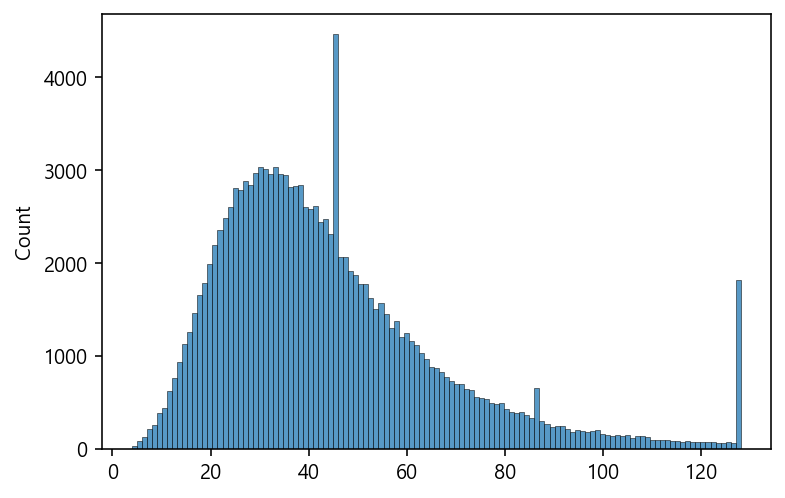

In [26]:
# truncation 확인
sns.histplot([len(i) for i in train_ds['input_ids']])

# Model Load

In [20]:
final_model

'./output/checkpoint-12700/'

In [21]:
# BERT Pre-trained Model
model = BertForSequenceClassification.from_pretrained(final_model, #model_path,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [22]:
from transformers.data.data_collator import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1_micro = f1_score(y_true=labels, y_pred=pred, average='micro')
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    
    return {"accuracy": accuracy, "f1_micro": f1_micro, 'f1_macro': f1_macro, 'recall': recall, 'precision': precision}

batchify = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
)

In [23]:
# mini-batch 구성확인
batchify(train_ds[:2])

{'labels': tensor([1, 2]), 'input_ids': tensor([[27710,  2699,  6824,  9786,  2533,  6700,  4870,  5892,  7850,  2482,
         10052,  8358,  2480,  5708,  8785,  7148,  5725,  2633,  1314,  5155,
            16,  5630,  7648, 14884,  2487,  6608,  4878,  5461,  5228,  4933,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 1067,  9494,  5040, 11373,  7489,  2482,  6924,  3072, 22266, 11373,
          4953,  6924,  2838,  5653,  5055,  8066,  4966, 39524, 19657,  2490,
         10968,  1363,  6529,    16,  7442,  9776,  8306, 16164,  4987,  6077,
         11002, 18875,  6200,    16,  8697, 27477,  2482, 11179,    16, 23056,
          4860,  9411,  2494,  6550, 10968,   561,  1363,  4866,    18]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [24]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,          
    evaluation_strategy="epoch",
    eval_steps=1000,
    per_device_train_batch_size=128, 
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    adam_beta1=.9,
    adam_beta2=.95,
    adam_epsilon=1e-8,
    max_grad_norm=1.,
    optim = 'adamw_hf',
    num_train_epochs=50,    
    lr_scheduler_type="linear",
    warmup_steps=100,
    logging_dir='./logs',
    logging_strategy="epoch",
    logging_first_step=True,
    logging_steps=1000,
    save_strategy="epoch",
    seed=12345,
    dataloader_drop_last=False,
    dataloader_num_workers=2,
    report_to = 'wandb',
    run_name="TechBERT"  # name of the W&B run (optional)
)

trainer = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

In [25]:
trainer.train()

/home1/hyez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 129884
  Num Epochs = 50
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 1
  Total optimization steps = 12700
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: hyez. Use `wandb login --relogin` to force relogin


/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall,Precision
1,0.658500,0.372715,0.863204,0.863204,0.836403,0.863204,0.863204
2,0.309700,0.358675,0.871658,0.871658,0.853172,0.871658,0.871658
3,0.220500,0.379137,0.870126,0.870126,0.853052,0.870126,0.870126
4,0.153600,0.434099,0.870865,0.870865,0.854525,0.870865,0.870865
5,0.106100,0.504382,0.865476,0.865476,0.847881,0.865476,0.865476
6,0.077700,0.529814,0.869333,0.869333,0.856514,0.869333,0.869333
7,0.061500,0.610275,0.867801,0.867801,0.852024,0.867801,0.867801
8,0.051100,0.615289,0.865212,0.865212,0.850766,0.865212,0.865212
9,0.042500,0.673509,0.863997,0.863997,0.845417,0.863997,0.863997
10,0.037100,0.670515,0.864684,0.864684,0.849996,0.864684,0.864684


***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-254
Configuration saved in ./output/checkpoint-254/config.json
Model weights saved in ./output/checkpoint-254/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-508
Configuration saved in ./output/checkpoint-508/config.json
Model weights saved in ./output/checkpoint-508/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a 

Configuration saved in ./output/checkpoint-4064/config.json
Model weights saved in ./output/checkpoint-4064/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-4318
Configuration saved in ./output/checkpoint-4318/config.json
Model weights saved in ./output/checkpoint-4318/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples

/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-8128
Configuration saved in ./output/checkpoint-8128/config.json
Model weights saved in ./output/checkpoint-8128/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-8382
Configuration saved in ./output/checkpoint-838

***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-11938
Configuration saved in ./output/checkpoint-11938/config.json
Model weights saved in ./output/checkpoint-11938/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 18926
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-12192
Configuration saved in ./output/checkpoint-12192/config.json
Model weights saved in ./output/checkpoint-12192/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze a

TrainOutput(global_step=12700, training_loss=0.04156467532900375, metrics={'train_runtime': 10477.9196, 'train_samples_per_second': 619.799, 'train_steps_per_second': 1.212, 'total_flos': 4.271941058507405e+17, 'train_loss': 0.04156467532900375, 'epoch': 50.0})

## Evaluate

In [30]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 36726
  Batch size = 32
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: hyez. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.8843409419059753,
 'eval_accuracy': 0.9078309644393617,
 'eval_f1_micro': 0.9078309644393617,
 'eval_f1_macro': 0.9108687014819773,
 'eval_recall': 0.9078309644393617,
 'eval_precision': 0.9078309644393617,
 'eval_runtime': 103.3469,
 'eval_samples_per_second': 355.366,
 'eval_steps_per_second': 11.108}

# predict

In [25]:
out = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 36726
  Batch size = 32


In [26]:
out

PredictionOutput(predictions=array([[-2.862384  , -2.158849  , -1.4125412 , ..., -2.3627641 ,
        -3.0155668 , -2.5931058 ],
       [-1.6986306 , -2.0602121 , 13.641223  , ..., -1.273051  ,
        -1.7525449 , -1.2666978 ],
       [-0.28530732, -0.11483537, -1.6389393 , ..., -1.5987687 ,
         0.42033026, 11.673394  ],
       ...,
       [-1.5987202 , -1.3299098 , -1.4661098 , ..., -2.3734047 ,
        -1.376052  , -1.600936  ],
       [-1.8573161 , -2.1491609 , -0.9303596 , ..., -3.830178  ,
        -2.4681501 , -2.1512015 ],
       [-1.88001   , -2.1349585 , -1.2901493 , ..., -3.6004655 ,
        -2.626451  , -2.1330366 ]], dtype=float32), label_ids=array([ 5,  2, 12, ...,  4,  3,  3], dtype=int64), metrics={'test_loss': 0.8843409419059753, 'test_accuracy': 0.9078309644393617, 'test_f1_micro': 0.9078309644393617, 'test_f1_macro': 0.9108687014819773, 'test_recall': 0.9078309644393617, 'test_precision': 0.9078309644393617, 'test_runtime': 102.9005, 'test_samples_per_second': 35

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
y_true = out[1]
y_pred = np.argmax(out[0], axis=1)

print('-'*10, 'confusion matrix(row:true, column:prediction)', '-'*10)
print(confusion_matrix(y_true, y_pred))
print('\n\n', '-'*10, 'classification report', '-'*10)
print(classification_report(y_true, y_pred, target_names=list(label_dict.keys())))

---------- confusion matrix(row:true, column:prediction) ----------
[[ 824   21    0    0    0    0    0    3    1    0    0    8    4]
 [  32 1357    3    3    4    2    0    8    3    0    1   49    9]
 [   3    6 6699   71   24   11    6  161    8   14    5    1    0]
 [   0    2   66 3697  240  427  181    6   13  142    9    0    0]
 [   0    1   17  182 3716   13   32    3   10   11    1    0    0]
 [   0    0   10  268   10 2630   10   14    2    3    1    0    0]
 [   0    0    8  185   49   12 1855    0   19   71    5    0    0]
 [   1    1  116    6    2   20    0 3348    0    1    4    0    0]
 [   0    0   12   18    8    3    9    1 2382    0    2    0    0]
 [   0    1   10  265   29    7   95    0    6 2263    4    0    0]
 [   0    0    9   15    6    5    1    0    3    1  569    0    0]
 [   8   46    1    0    1    0    0    0    1    0    0 3128   69]
 [  12   18    0    0    0    0    0    0    0    0    0   84  873]]


 ---------- classification report ----------


In [45]:
label_dict_inv = {v: i for i, v in label_dict.items()}

In [136]:
mydict = {'target' :[],
            'prediction': [],
          'text' :[]}
for t in range(13):
    for p in range(13):
        true, pred = t, p
        pred_df = pd.DataFrame({'prediction':y_pred.tolist(), 'target':y_true.tolist()})
        if pred_df[(pred_df.prediction==pred)&(pred_df.target==true)].shape[0] != 0:
            
            for i in test.iloc[list(pred_df[(pred_df.prediction==pred)&(pred_df.target==true)].index)].text:
                mydict['prediction'].append(label_dict_inv[p])
                mydict['target'].append(label_dict_inv[t])
                mydict['text'].append(i)

In [137]:
pd.DataFrame(mydict).to_csv('./error_test.csv', encoding='utf-8-sig', index = False)

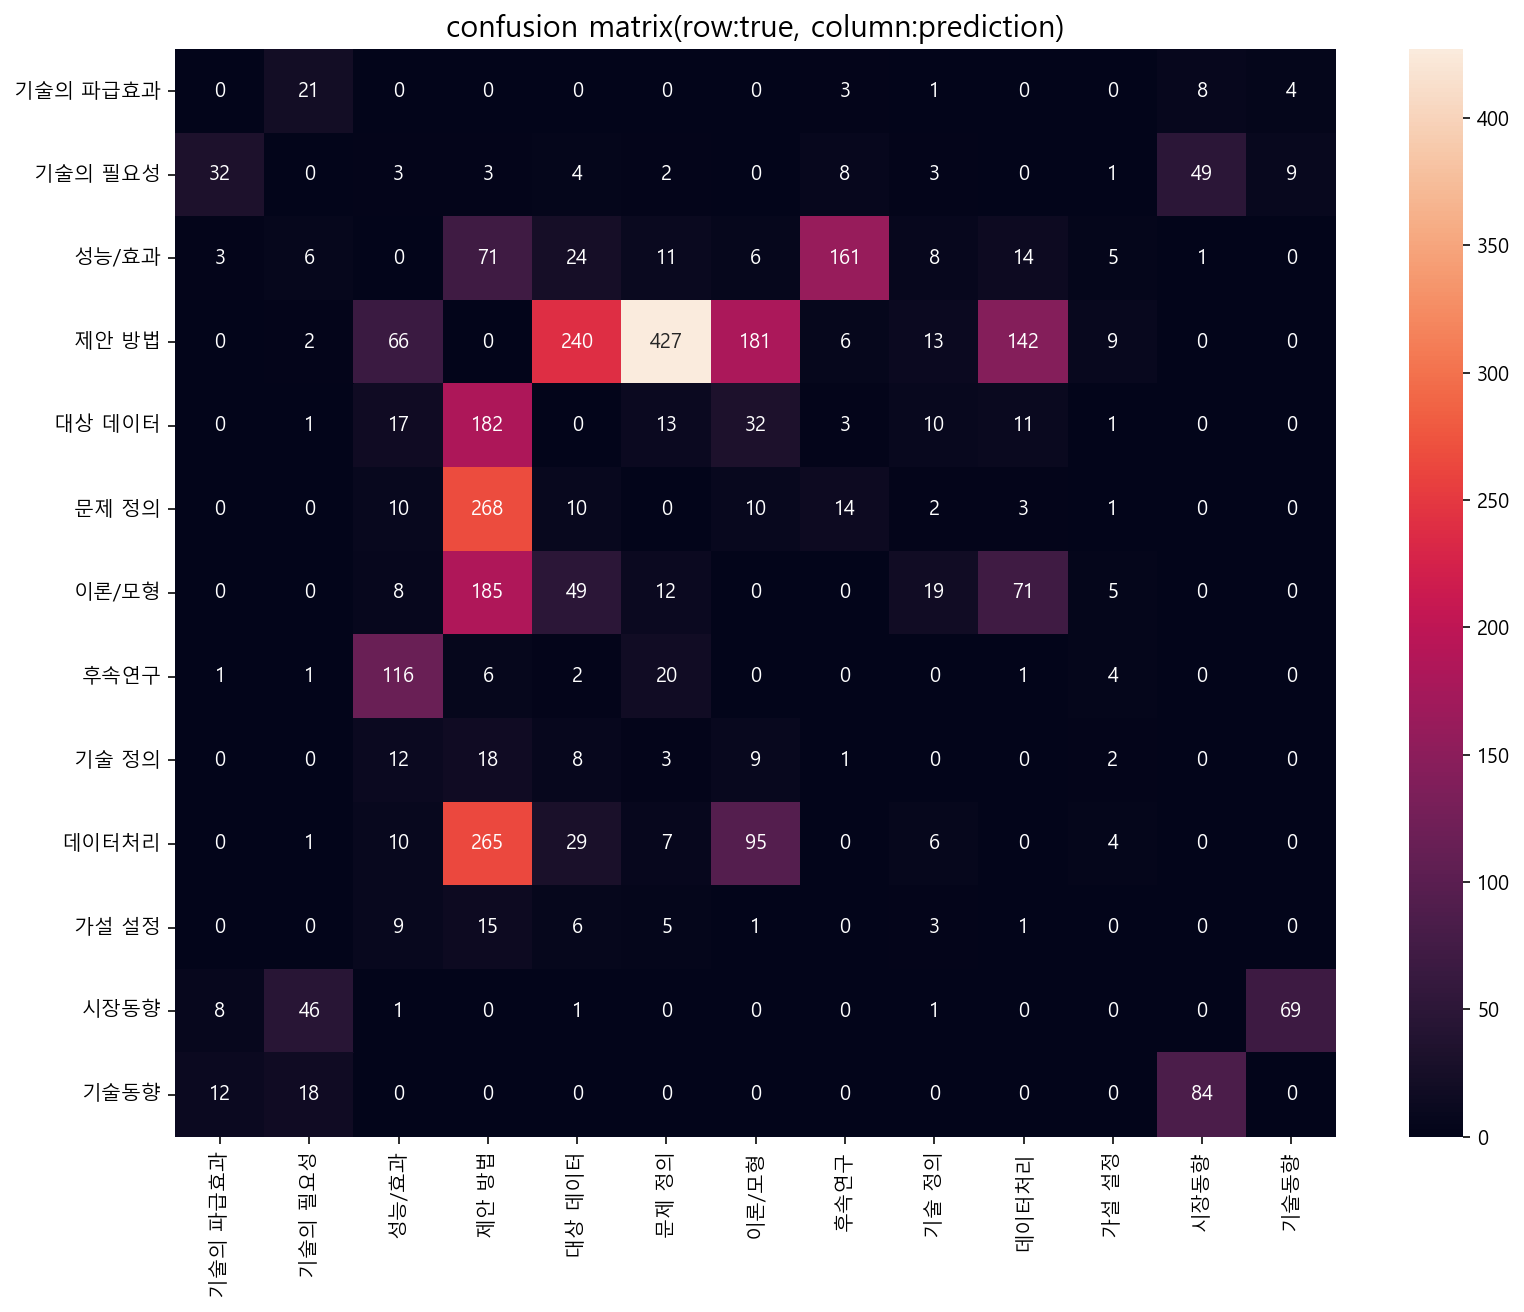

In [86]:
plt.figure(figsize=(13, 10))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred) - np.diag(np.diag(confusion_matrix(y_true, y_pred))), columns =list(label_dict.keys()), index = list(label_dict.keys())), annot=True, fmt='d')
plt.title('confusion matrix(row:true, column:prediction)', fontsize=15)
plt.show()

In [87]:
pd.DataFrame(confusion_matrix(y_true, y_pred) - np.diag(np.diag(confusion_matrix(y_true, y_pred))), columns =list(label_dict.keys()), index = list(label_dict.keys()))

,기술의 파급효과,기술의 필요성,성능/효과,제안 방법,대상 데이터,문제 정의,이론/모형,후속연구,기술 정의,데이터처리,가설 설정,시장동향,기술동향
기술의 파급효과,0,21,0,0,0,0,0,3,1,0,0,8,4
기술의 필요성,32,0,3,3,4,2,0,8,3,0,1,49,9
성능/효과,3,6,0,71,24,11,6,161,8,14,5,1,0
제안 방법,0,2,66,0,240,427,181,6,13,142,9,0,0
대상 데이터,0,1,17,182,0,13,32,3,10,11,1,0,0
문제 정의,0,0,10,268,10,0,10,14,2,3,1,0,0
이론/모형,0,0,8,185,49,12,0,0,19,71,5,0,0
후속연구,1,1,116,6,2,20,0,0,0,1,4,0,0
기술 정의,0,0,12,18,8,3,9,1,0,0,2,0,0
데이터처리,0,1,10,265,29,7,95,0,6,0,4,0,0


In [44]:
list(label_dict.keys())

['기술의 파급효과',
 '기술의 필요성',
 '성능/효과',
 '제안 방법',
 '대상 데이터',
 '문제 정의',
 '이론/모형',
 '후속연구',
 '기술 정의',
 '데이터처리',
 '가설 설정',
 '시장동향',
 '기술동향']

# Best Model Checkpoint

In [49]:
len(os.listdir('./output'))
best_acc_path = os.listdir('./output')[1]
best_f1_path = os.listdir('./output')[5]

In [53]:
# BERT Pre-trained Model
model_acc = BertForSequenceClassification.from_pretrained('./output/'+best_acc_path,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model_f1 = BertForSequenceClassification.from_pretrained('./output/'+best_f1_path,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

loading configuration file ./output/checkpoint-508/config.json
Model config BertConfig {
  "_name_or_path": "./40ep_train9/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
 

In [55]:
trainer_acc = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model_acc,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

trainer_f1 = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model_f1,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

In [57]:
trainer_acc.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 36739
  Batch size = 512
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.3586953580379486,
 'eval_accuracy': 0.8698930292060209,
 'eval_f1_micro': 0.8698930292060209,
 'eval_f1_macro': 0.8482307699894137,
 'eval_recall': 0.8698930292060209,
 'eval_precision': 0.8698930292060209,
 'eval_runtime': 27.9643,
 'eval_samples_per_second': 1313.782,
 'eval_steps_per_second': 2.575}

In [56]:
trainer_f1.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 36739
  Batch size = 512
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
***** Running Evaluation *****
  Num examples = 36739
  Batch size = 512
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 0.5165570378303528,
 'eval_accuracy': 0.8717983614143009,
 'eval_f1_micro': 0.8717983614143009,
 'eval_f1_macro': 0.8583376749304781,
 'eval_recall': 0.8717983614143009,
 'eval_precision': 0.8717983614143009,
 'eval_runtime': 28.0147,
 'eval_samples_per_second': 1311.419,
 'eval_steps_per_second': 2.57}